__Attempt to recreate the result of the paper "Epileptic Seizure Detection Using a
Convolutional Neural Network" by "Bassem Bouaziz, Lotfi Chaari, Hadj Batatia, and Antonio Quintero-Rincón"__

Paper:
https://oatao.univ-toulouse.fr/24138/1/Bouaziz_24138.pdf

Dataset:
https://physionet.org/content/chbmit/1.0.0/

In [1]:
# %matplotlib notebook
import os
import numpy as np
import mne

from matplotlib.widgets import Slider
import matplotlib.pyplot as plt
from datetime import datetime

import re

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.advanced_activations import LeakyReLU

In [3]:
# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)

Read one file from CHB-MIT dataset of epileptic seizures. https://physionet.org/content/chbmit/1.0.0/

In [4]:
%%capture
file_path = 'C:\\Users\\agfrxa\\CHB-MIT\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb04\\chb04_28.edf'
raw_eeg = mne.io.read_raw(file_path)
chs = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3','F3-C3','C3-P3','P3-O1','FP2-F4','F4-C4','C4-P4',
       'P4-O2','FP2-F8','F8-T8','T8-P8-0','P8-O2','FZ-CZ','CZ-PZ','P7-T7','T7-FT9','FT9-FT10','FT10-T8','T8-P8-1']
eeg_array = raw_eeg[chs][0]

Creates two dictionaries where the file name is the key and an array is the value. The array contains the time interval(s) that are either seizure interval or non-seizure interval. E.g the interval [120, 150] in the seizure_dict means that a seizure starts at 120 seconds and stops at 150 seconds. It does this by looping through the summary text-files providied with the data set.

In [5]:
def Get_seizure_non_seizure_dict(path, sampling_frequenc=256):
    summary_path = path + '\\chb'+ path[-2::] +'-summary.txt'
    date_format_str = '%H:%M:%S'
    diffs = []
    seizure_dict = {}
    non_seizure_dict = {}
    with open(summary_path) as txt:
        summary = txt.readlines()
    
    for line in summary:
        file_name = re.search(r"File Name: chb([0-9]*)(|([a-z]))_([0-9]*)(|([+])).edf", line)
        seizure_start_time = re.search(r"Seizure(| ([0-9]*)) Start Time:( |  )([0-9]*) seconds", line)
        seizure_end_time = re.search(r"Seizure(| ([0-9]*)) End Time:( |  )([0-9]*) seconds", line)

        if file_name:
            current_filename = file_name[0].split()[2]
        if seizure_start_time:
            current_start_time = int(seizure_start_time[0].split()[-2])
        if seizure_end_time:
            current_end_time = int(seizure_end_time[0].split()[-2])
            if current_filename in seizure_dict:
                seizure_dict[current_filename] = np.vstack((seizure_dict[current_filename], np.array([current_start_time, current_end_time])))
            else:
                seizure_dict[current_filename] = np.array([np.array([current_start_time, current_end_time])])
                
        test_start_time = re.search(r"File Start Time: ([0-9]*):([0-9]*):([0-9]*)", line)
        test_end_time = re.search(r"File End Time: ([0-9]*):([0-9]*):([0-9]*)", line)

        if test_start_time:
            current_test_start_time = str(test_start_time[0].split()[-1])

        if test_end_time:
            current_test_end_time = str(test_end_time[0].split()[-1])
            if int(current_test_start_time[0]) == 2:
                current_test_start_time = current_test_start_time.replace('2', '1', 1)
                current_test_end_time = current_test_end_time.replace('2', '1', 1)
                

            start = datetime.strptime(current_test_start_time, date_format_str)
            end = datetime.strptime(current_test_end_time, date_format_str)
            diffs.append(int((end - start).total_seconds()))
            
    
    file_list = os.listdir(path)
    edf_list = [file for file in file_list if 'seizures' not in file and 'txt' not in file]
        
    for num, edf_file_name in enumerate(edf_list):
        if edf_file_name in seizure_dict:
            non_seizure_dict[edf_file_name] = np.array([np.array([0, seizure_dict[edf_file_name][0,0]])])
            for i in range(len(seizure_dict[edf_file_name]) - 1):
                current_start_time = seizure_dict[edf_file_name][i][1]
                current_end_time = seizure_dict[edf_file_name][i+1][0]
                non_seizure_dict[edf_file_name] = np.vstack((non_seizure_dict[edf_file_name], np.array([current_start_time, current_end_time])))

            non_seizure_dict[edf_file_name] = np.vstack((non_seizure_dict[edf_file_name], np.array([seizure_dict[edf_file_name][-1,-1], diffs[num]])))
        else:
            non_seizure_dict[edf_file_name] = np.array([np.array([0, diffs[num]])])
            
    return seizure_dict, non_seizure_dict

path = 'C:\\Users\\agfrxa\\CHB-MIT\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0\\chb04'

seizure_dict, non_seizure_dict = Get_seizure_non_seizure_dict(path, sampling_frequenc=256)

In [6]:
folder_path = 'C:\\Users\\agfrxa\\CHB-MIT\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0'
def Generate_global_seizure_dict(folder_path):
    path = folder_path + '\\chb{value:02d}'
    seizure_dict = {}
    for i in range(1,24):
        summary_path = path.format(value = i)
        temp_seizure_dict, non_seizure_dict = Get_seizure_non_seizure_dict(summary_path)
        seizure_dict.update(temp_seizure_dict)
        
    return seizure_dict

def Calculate_total_seizure_time(glob_seizure_dict):
    tot_seiz_time = 0
    for key in glob_seizure_dict:
        no_seizures = len(glob_seizure_dict[key])
        for i in range(no_seizures):
            tot_seiz_time += glob_seizure_dict[key][0][1]-glob_seizure_dict[key][0][0]

    return tot_seiz_time
glob_seizure_dict = Generate_global_seizure_dict(folder_path)
tot_seiz_time = Calculate_total_seizure_time(glob_seizure_dict)


Loads an edf-file and creates an array with the 23 channels in the list chs. These channels are present in almost all of the edf-files.

In [7]:
def load_epileptic_edf_file(folder_path, key, seizure_dict):
    chs = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3','F3-C3','C3-P3','P3-O1','FP2-F4','F4-C4','C4-P4',
       'P4-O2','FP2-F8','F8-T8','T8-P8-0','P8-O2','FZ-CZ','CZ-PZ','P7-T7','T7-FT9','FT9-FT10','FT10-T8','T8-P8-1']
    directories = [dirc for dirc in os.listdir(folder_path) if 'chb' in dirc]

    edf_path = folder_path + '\\' + key[0:5] + '\\' + key
    return mne.io.read_raw(edf_path)[chs][0]

In [8]:
def Rowwise_normalization(eeg_array):
    np.shape(eeg_array)
    temp_eeg = eeg_array
    norm_eeg = temp_eeg.transpose() - np.amin(temp_eeg, axis=1).transpose()
    return (norm_eeg / np.amax(norm_eeg, axis=0)).transpose()

def Normalize(eeg_array):
    min_value = np.min(eeg_array)
    new_array = (eeg_array-min_value)
    return new_array/np.max(new_array)
row_normalized_eeg = Rowwise_normalization(eeg_array)

A plot showing a seizure between the two red lines. The eeg-arrays are normalized rowwise and plotted as a heatmap where the color corresponds to the amplitude of the signal at that point. This, split into parts, is what the network will be trained on.

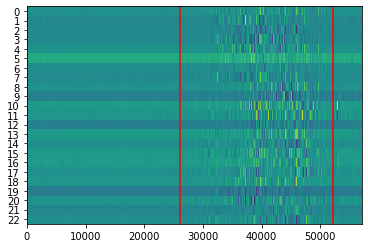

In [9]:
plt.figure()
plt.imshow(row_normalized_eeg[:,1577*256:1800*256], interpolation='nearest', aspect='auto')
plt.locator_params(axis='y', nbins=24)
plt.axvline(x=(1679-1577)*256, c='r')
plt.axvline(x=(1781-1577)*256, c='r')


This function takes an array and a corresponding seizure_dict and extracts an interval (in this case a 23x512 array) corresponding to a seizure. These intervals are stacked on top of eachother to create a training set. It also outputs an array of labels the same length as the number of stacked intervals.

In [10]:
def Generate_seizure_or_non_seizure_sample(eeg_array, seizure_dict, label, sample_len=2, 
                         edf_file_name='chb04_28.edf', 
                         sampling_frequency=256):
    
    no_of_seizures = len(seizure_dict[edf_file_name])
    no_of_samples_list = [0]
    
    for i in range(no_of_seizures):
        no_of_samples_list.append(int((seizure_dict[edf_file_name][i][1] - seizure_dict[edf_file_name][i][0]) / sample_len))
        
    no_of_samples = sum(no_of_samples_list)
    seizures = np.zeros((no_of_samples, np.shape(eeg_array)[0], sample_len*sampling_frequency))

    for i in range(no_of_seizures):
        start_col = seizure_dict[edf_file_name][i][0] * sampling_frequency
        start_index_in_array = sum(no_of_samples_list[0:i+1])
        
        stop_index_in_array = start_index_in_array + no_of_samples_list[i+1]
        
        for iterator, index in enumerate(range(start_index_in_array, stop_index_in_array)):
            col1 = start_col + iterator * sample_len * sampling_frequency
            col2 = start_col + (iterator+1) * sample_len * sampling_frequency
            
            seizures[index,:,:] = eeg_array[:, col1:col2]

    images_in_set = np.shape(seizures)[0]
    labels = np.ones(images_in_set)*label
    return seizures, labels


edf_file_name = list(seizure_dict.keys())[0]

seizures, labels = Generate_seizure_or_non_seizure_sample(eeg_array, seizure_dict, label=1, sample_len=2, 
                         edf_file_name=edf_file_name, 
                         sampling_frequency=256)

This function combines previous created functions and loops over all of the files in the data set to create a training set ready to be used by our model. The training set is shuffled before it is returned by the function. Some files are removed from the data set due to reasons such as them not containing the same number of channels etc.

In [11]:
%%capture
folder_path = 'C:\\Users\\agfrxa\\CHB-MIT\\chb-mit-scalp-eeg-database-1.0.0\\chb-mit-scalp-eeg-database-1.0.0'
def Generate_seizure_set(folder_path):
    glob_seizure_dict = Generate_global_seizure_dict(folder_path)
    tot_seiz_time = Calculate_total_seizure_time(glob_seizure_dict)
    content = os.listdir(folder_path)
    folder_list = [file for file in content if 'chb' in file][0:-1]
    seizures = np.zeros((1,23,512))
    non_seizures = np.zeros((1,23,512))
    labels = np.array([])
    non_labels = np.array([])
    for path_iter in folder_list:
        path = folder_path + '\\' + path_iter
        seizure_dict, non_seizure_dict = Get_seizure_non_seizure_dict(path)
        
        if 'chb12_27.edf' in seizure_dict:
            seizure_dict.pop('chb12_27.edf')
            seizure_dict.pop('chb12_28.edf')
            seizure_dict.pop('chb12_29.edf')
            
        if 'chb13_40.edf' in seizure_dict:
            seizure_dict.pop('chb13_40.edf')
        
        if 'chb16_18.edf' in seizure_dict:
            seizure_dict.pop('chb16_18.edf')
            
        if 'chb04_28.edf' in seizure_dict:
            seizure_dict.pop('chb04_28.edf')
            
        for ind, key in enumerate(seizure_dict):
            eeg_array = load_epileptic_edf_file(folder_path, key, seizure_dict)
            eeg_array = Rowwise_normalization(eeg_array)

            temp_seizure_array, temp_labels = Generate_seizure_or_non_seizure_sample(eeg_array, seizure_dict, label=1, 
                                                                                     sample_len=2, 
                                                                                     edf_file_name=key, 
                                                                                     sampling_frequency=256)
            
            temp_non_seizure_array, temp_non_labels = Generate_seizure_or_non_seizure_sample(eeg_array, non_seizure_dict, 
                                                                                             label=0, 
                                                                                             sample_len=2, 
                                                                                             edf_file_name=key, 
                                                                                             sampling_frequency=256)
            
            seizures = np.append(seizures, temp_seizure_array, axis=0)
            labels = np.append(labels, temp_labels)
            
            no_of_samples = np.shape(temp_seizure_array)[0]
            non_seizures = np.append(non_seizures, temp_non_seizure_array[0:no_of_samples], axis=0)
            non_labels = np.append(non_labels, temp_non_labels[0:no_of_samples])
    
    
    training_set = np.append(seizures[1::], non_seizures[1::], axis=0)
    training_set = np.expand_dims(training_set, axis=-1)
    labels = np.append(labels, non_labels)
        
    seed=np.random.randint(2e9)
    tf.random.set_seed(seed)
    training_set = tf.random.shuffle(training_set,seed)
        
    tf.random.set_seed(seed)
    labels = tf.random.shuffle(labels,seed)
        
    return training_set, labels

training_set, labels = Generate_seizure_set(folder_path)

A LeNet is generated, but with the sigmoid functions replaced by ReLu functions.

In [15]:
sampling_frequency = 256
sample_len = 2
input_shape = (10, 23, sampling_frequency*sample_len, 1)

model = tf.keras.models.Sequential([
    keras.Input(shape=input_shape[1:]),
    layers.Conv2D(6, 5, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 5, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(1),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 23, 512, 6)        156       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 256, 6)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 252, 16)        2416      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 126, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6048)              0         
                                                                 
 dense_3 (Dense)             (None, 120)              

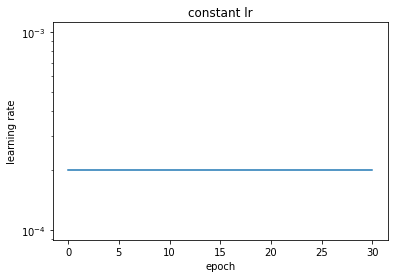

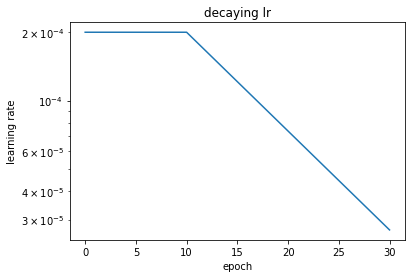

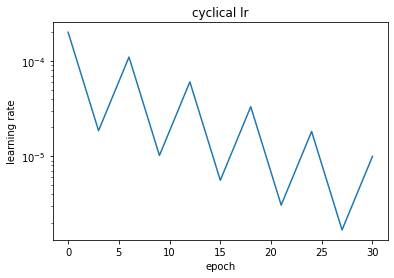

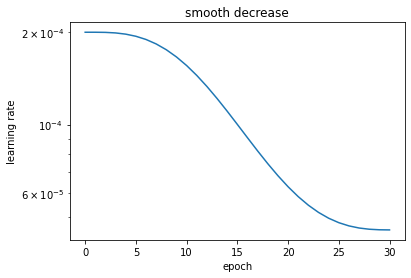

In [16]:
learning_rate=2e-4

def fill_lr_vector(lr, scheduler):
    lr_vector = np.ones(31)*2e-4
    for epoch in range(30):
        lr_vector[epoch+1] = scheduler(epoch, lr_vector[epoch])
    return lr_vector

def scheduler(epoch, lr):
    return lr

lr_vector = fill_lr_vector(learning_rate, scheduler)
plt.figure()
plt.plot(lr_vector)
plt.title('constant lr')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')

def scheduler0(epoch, lr):
    if epoch < 10:
        return lr
    elif lr < 1e-6:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_vector = fill_lr_vector(learning_rate, scheduler0)
plt.figure()
plt.plot(lr_vector)
plt.title('decaying lr')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')
    
def scheduler1(epoch, lr):
    cycle = np.array([0.5, 0.5, 0.5, 2, 2, 2])
    if lr > 1e-7:
        return lr * cycle[epoch % 6] * tf.math.exp(-0.1)
    else:
        return lr * cycle[epoch % 6]

    
lr_vector = fill_lr_vector(learning_rate, scheduler1)
plt.figure()
plt.plot(lr_vector)
plt.title('cyclical lr')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')


def scheduler2(epoch, lr):
    if lr < 1e-6:
        return lr
    return lr * (np.cos(np.pi*2*(epoch/30))+20)/21


lr_vector = fill_lr_vector(learning_rate, scheduler2)
plt.figure()
plt.plot(lr_vector)
plt.title('smooth decrease')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')

In [17]:
loss_fn = tf.keras.losses.BinaryCrossentropy()

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt,
              loss=loss_fn,
              metrics=['accuracy'])


callback = tf.keras.callbacks.LearningRateScheduler(scheduler0)

history = model.fit(training_set, labels, epochs=30, validation_split=0.8, batch_size=10, callbacks = [callback])

Epoch 1/30
202/202 [==============================] - 10s 50ms/step - loss: 0.6993 - accuracy: 0.5885 - val_loss: 0.6497 - val_accuracy: 0.6317 - lr: 2.0000e-04
Epoch 2/30
202/202 [==============================] - 10s 49ms/step - loss: 0.6457 - accuracy: 0.6143 - val_loss: 0.6200 - val_accuracy: 0.6397 - lr: 2.0000e-04
Epoch 3/30
202/202 [==============================] - 10s 50ms/step - loss: 0.6304 - accuracy: 0.6346 - val_loss: 0.6011 - val_accuracy: 0.6534 - lr: 2.0000e-04
Epoch 4/30
202/202 [==============================] - 10s 51ms/step - loss: 0.5961 - accuracy: 0.6733 - val_loss: 0.6135 - val_accuracy: 0.6612 - lr: 2.0000e-04
Epoch 5/30
202/202 [==============================] - 10s 52ms/step - loss: 0.5971 - accuracy: 0.6718 - val_loss: 0.6018 - val_accuracy: 0.6561 - lr: 2.0000e-04
Epoch 6/30
202/202 [==============================] - 10s 49ms/step - loss: 0.5902 - accuracy: 0.6708 - val_loss: 0.5791 - val_accuracy: 0.6700 - lr: 2.0000e-04
Epoch 7/30
202/202 [==============

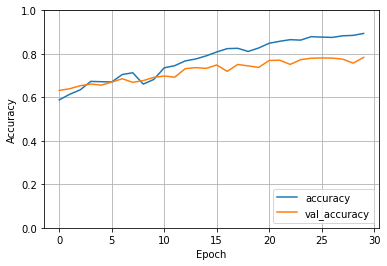

In [18]:
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True)
# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

Now we can verify how well our model works. The file used below (chb04_28.edf) was excluded from our training data. How the model predicts on one of its seizures is shown below. And again, the area within the red borders is labeled as seizure in the data set and the area above the yellow line is what the model predicted as a seizure.

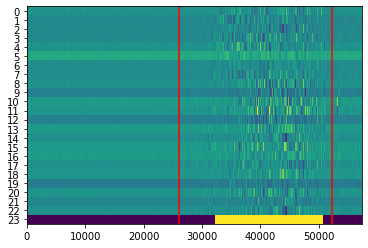

In [19]:
interval_to_predict = row_normalized_eeg[:,1576*256:1800*256]
no_samples = int(np.shape(interval_to_predict)[1]/512)
test_set = np.zeros((112,23,512,1))
for i in range(no_samples):
    test_set[i,:,:,0] = interval_to_predict[:,i*512:(i+1)*512]
    
predictions = model.predict(test_set)
predictions = np.round(predictions)
label_line = np.zeros((1, 512*no_samples))
for i in range(no_samples):
    label_line[0,i*512:(i+1)*512] = predictions[i]
    
label_line[label_line > 1]=1
interval_with_labels = np.append(interval_to_predict, label_line, axis=0)

plt.figure()
plt.imshow(interval_with_labels, interpolation='nearest', aspect='auto')
plt.locator_params(axis='y', nbins=24)
plt.axvline(x=(1679-1577)*256, c='r')
plt.axvline(x=(1781-1577)*256, c='r')
